# RFM Analysis for Walmart

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

Walmart aims to enhance its customer engagement and marketing effectiveness by better understanding shopper behavior. Traditionally, customer loyalty has been evaluated through broad metrics like total sales or purchase frequency. However, Walmart believes that a more granular approach, such as analyzing how recently customers shopped, how frequently they purchase, and how much they spend, can provide deeper insights into customer value. This project utilizes RFM (Recency, Frequency, Monetary) analysis to evaluate customer segmentation and identify high-value shoppers, ultimately helping Walmart tailor its strategies in a competitive retail landscape.

## Exploratory Data Analysis (EDA)

In [83]:
## Data Logic and Data Type
dft=pd.read_csv('Retail_Data_Transactions.csv')

In [84]:
dft.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [85]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [86]:
# Change data type of trans_date
dft['trans_date']=dft['trans_date'].astype('datetime64[ns]')

In [87]:
# Check duplicated data
print(dft.duplicated().sum())

6


In [88]:
# handling duplicated data
dft[dft.duplicated(keep=False)].sort_values('customer_id')

# There is a possibility that the customer simply do the same tran_amount at the same day, which cause a duplication. Hence, I will keep it

,customer_id,trans_date,tran_amount
8479,CS2565,2012-09-14,67
91603,CS2565,2012-09-14,67
12521,CS2700,2011-10-23,48
14324,CS2700,2011-10-23,48
45968,CS2761,2014-03-03,75
77236,CS2761,2014-03-03,75
5116,CS3458,2015-02-11,40
59852,CS3458,2015-02-11,40
103710,CS7782,2014-12-30,70
105496,CS7782,2014-12-30,70


## EDA Summary

- Transaction data inform about the recency (by the latest date), frequency from the number of customer_id, and monetary from the transaction amount
- The data is logic and no missing value
- The trans_date data need to be change to datetime data type to process the recency
- There are 6 duplicated data in transaction data, but no action needed as the assumption is the customer simply do the same transaction in the same day

## Data Preprocessing

### Recency

In [89]:
# create a new data frame
recency=dft[['customer_id','trans_date']]
recency['recency']=(recency['trans_date'].max()-recency['trans_date']).dt.days
recency['latest_trans_date']=recency['trans_date'].max()
recency[['customer_id','trans_date','latest_trans_date','recency']].sample(5)
# dataframe is ready

,customer_id,trans_date,latest_trans_date,recency
36773,CS3902,2015-02-15,2015-03-16,29
25842,CS5323,2012-08-20,2015-03-16,938
88742,CS2700,2012-02-21,2015-03-16,1119
79006,CS3659,2012-05-13,2015-03-16,1037
87026,CS4590,2012-03-17,2015-03-16,1094


In [90]:
# Grouping by customer_id
r=recency.groupby('customer_id').min('recency')
r

,recency
customer_id,
CS1112,61
CS1113,35
CS1114,32
CS1115,11
CS1116,203
...,...
CS8996,97
CS8997,261
CS8998,84


### Monetary

In [91]:
# Create a new data frame
m=dft.groupby('customer_id').sum('tran_amount')
m=m.rename(columns={'tran_amount':'monetary'})
m.head()

,monetary
customer_id,
CS1112,1012
CS1113,1490
CS1114,1432
CS1115,1659
CS1116,857


### Frequency

In [92]:
# Create a new data frame
f=dft.groupby('customer_id').count()
f=f[['trans_date']]
f=f.rename(columns={'trans_date':'frequency'})
f.head()

,frequency
customer_id,
CS1112,15
CS1113,20
CS1114,19
CS1115,22
CS1116,13


### Join tables

In [93]:
rfm=(pd.concat([r,f,m],axis=1)).reset_index()
rfm.head()

,customer_id,recency,frequency,monetary
0,CS1112,61,15,1012
1,CS1113,35,20,1490
2,CS1114,32,19,1432
3,CS1115,11,22,1659
4,CS1116,203,13,857


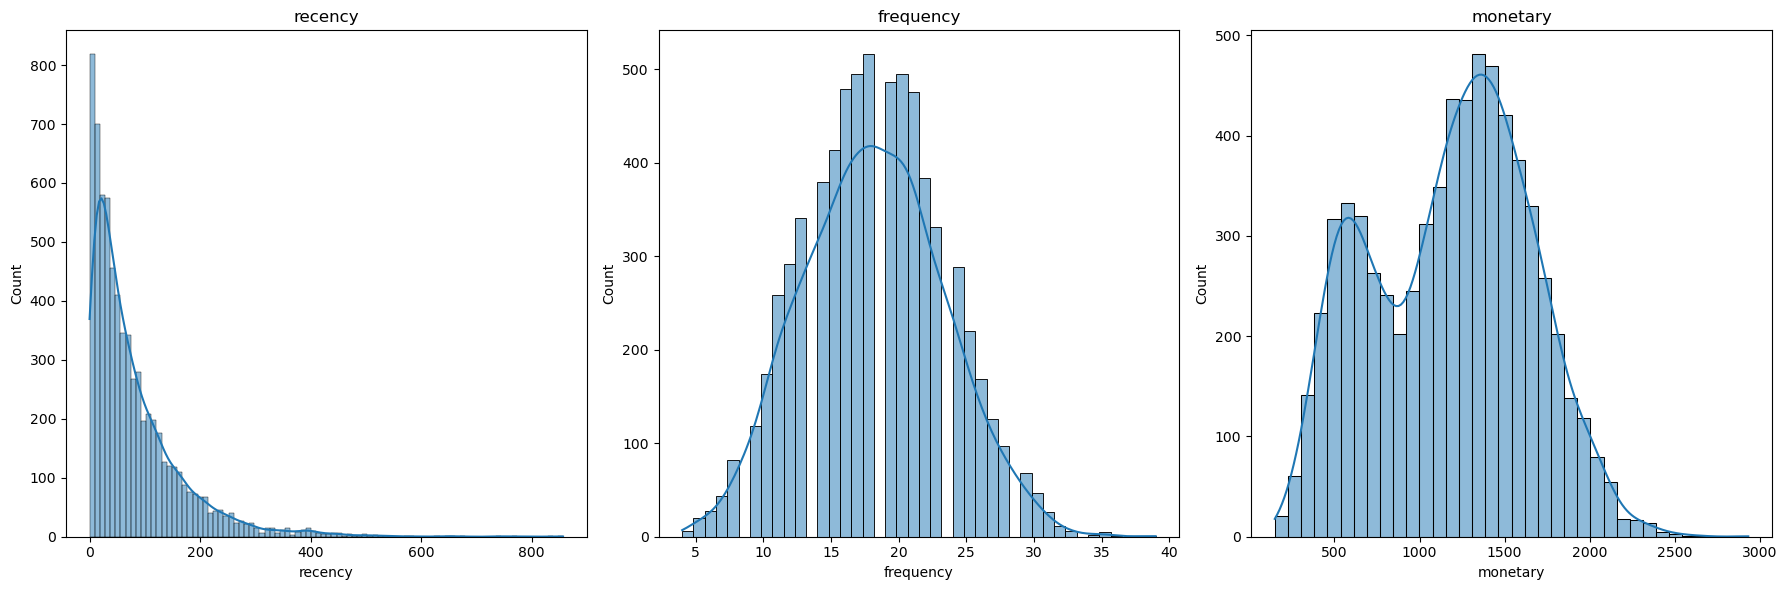

In [94]:
# Check distribution and outlier
features=['recency','frequency','monetary']
titles=['recency','frequency','monetary']

fig,axes=plt.subplots(1,3,figsize=(18,6))
for i, feature in enumerate(features):
    sns.histplot(rfm[feature],ax=axes[i],kde=True)
    axes[i].set_title(titles[i])
plt.tight_layout()

# recency and monetary has skewed distribution need to be changed.

In [95]:
# log transformation
rfm['recency_log']=np.log1p(rfm['recency'])
rfm['monetary_log']=np.log1p(rfm['monetary'])

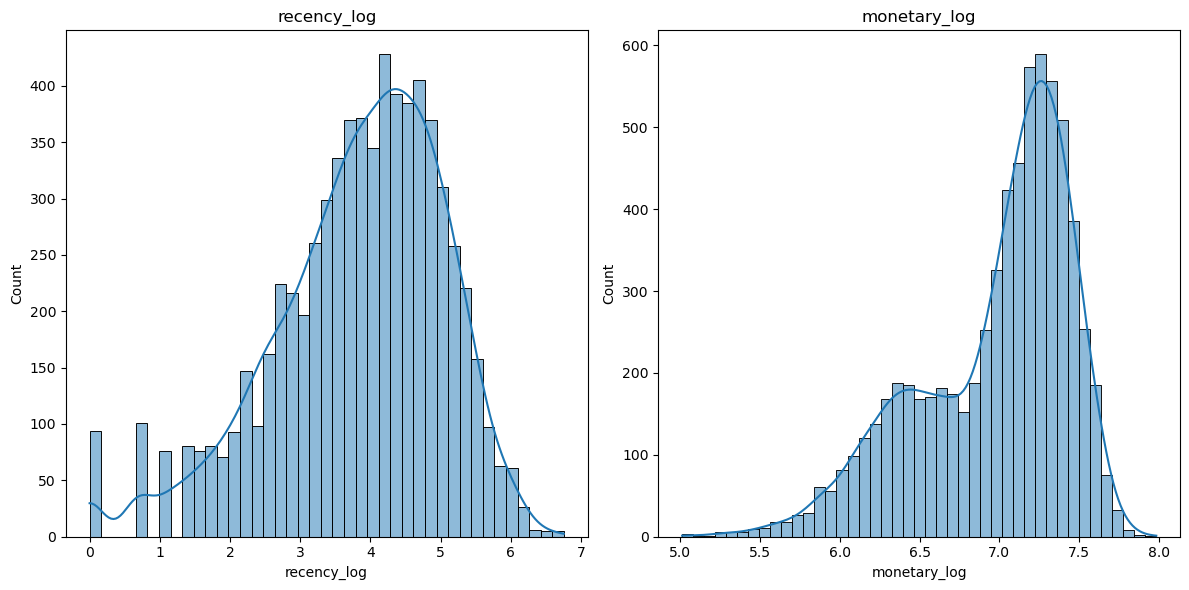

In [96]:
# Recheck the distribution
features_log=['recency_log','monetary_log']
titles_log=['recency_log','monetary_log']

fig,axes=plt.subplots(1,2,figsize=(12,6))
for i, feature in enumerate(features_log):
    sns.histplot(rfm[feature],ax=axes[i],kde=True)
    axes[i].set_title(titles_log[i])
plt.tight_layout()

#the distribution is better than before although still skewed, anyway, we can proceed to the clustering anyway.

In [97]:
# standardized rfm value for the clustering
x=rfm[['recency_log','frequency','monetary_log']]
x_scaled=StandardScaler().fit_transform(x)
final_rfm=pd.DataFrame(data=x_scaled,columns=features)
final_rfm.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-2.310373e-16,2.640426e-16,-5.610905e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-3.116471e+00,-2.724024e+00,-4.123632e+00
25%,-5.621932e-01,-7.982203e-01,-6.580080e-01
50%,1.330880e-01,-2.789885e-02,2.891660e-01
75%,7.273751e-01,7.424226e-01,7.382755e-01
max,2.386054e+00,4.016289e+00,2.117202e+00


## Data Preprocessing Summary

- Recency values are calculated by substracting the maximum date with the date for each transaction, resulting in number by days. Finally it was convert to int value
- frequency values are calculated using groupby function (count)
- monetary values are calculated using groupby function (sum)
- Skewed distribution in recency and monetary is handled by doing log transformation, although the result is not the best(still skewed) but it is way better than before
- final number is scaled as standardized is required for K-Means

## Modelling (K-Means)

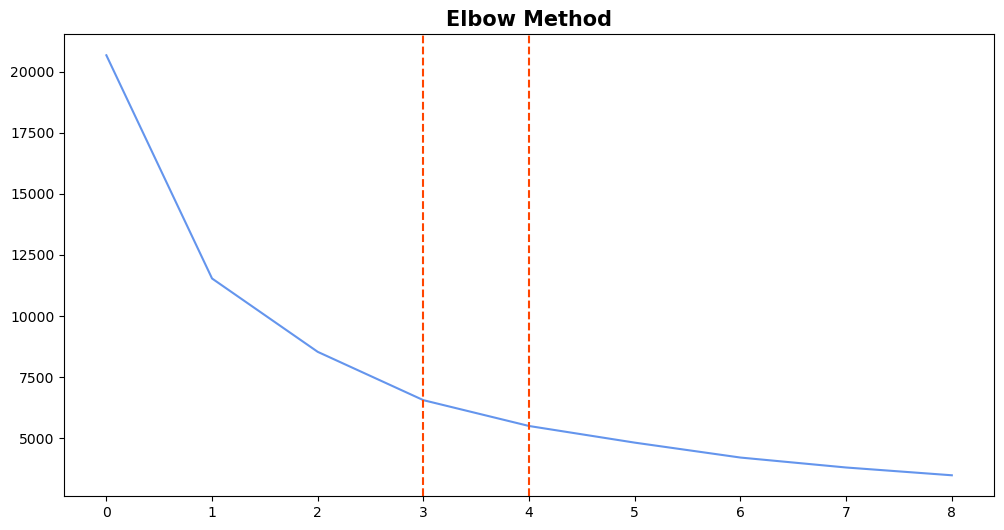

In [98]:
# find the best number of cluster using elbow method
inertia=[]
for i in range (1,10):
    kmeans1=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans1.fit(final_rfm.values)
    inertia.append(kmeans1.inertia_)

plt.figure(figsize=(12,6))
plt.plot(inertia, color='cornflowerblue')
plt.title('Elbow Method',fontsize=15,fontweight='bold')
plt.axvline(3,color='orangered',linestyle='--')
plt.axvline(4,color='orangered',linestyle='--');

# the best number of cluster is between 3 to 4 considering the significant steep there

In [99]:
# Clustering
kmeans3=KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans3.fit(final_rfm.values)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [100]:
kmeans4=KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans4.fit(final_rfm.values)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [101]:
#prepare the table that consist of rfm, response
rfm_final=rfm[['customer_id','recency','frequency','monetary']].copy()
rfm_final['cluster3']=kmeans3.labels_
rfm_final['cluster4']=kmeans4.labels_
rfm_final.head()

,customer_id,recency,frequency,monetary,cluster3,cluster4
0,CS1112,61,15,1012,1,3
1,CS1113,35,20,1490,0,1
2,CS1114,32,19,1432,0,3
3,CS1115,11,22,1659,2,2
4,CS1116,203,13,857,1,3


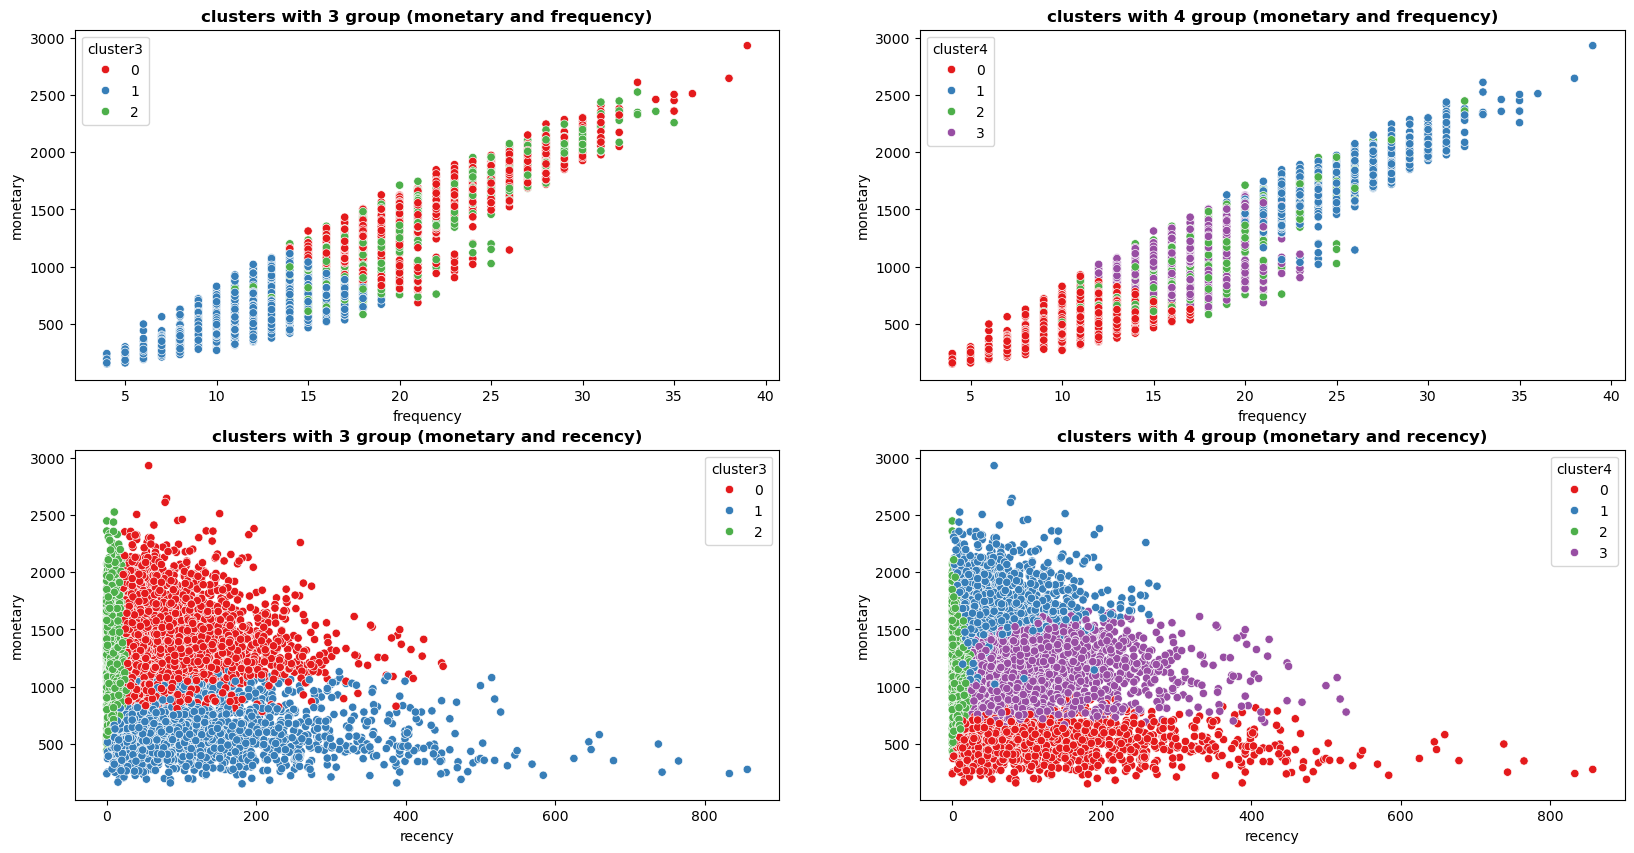

In [102]:
# check the distribution
fig,ax=plt.subplots(2,2,figsize=(20,10))

palette3=sns.color_palette('Set1',n_colors=3)
palette4=sns.color_palette('Set1',n_colors=4)
sns.scatterplot(data=rfm_final,x='frequency',y='monetary',hue='cluster3',palette=palette3,ax=ax[0,0])
sns.scatterplot(data=rfm_final,x='frequency',y='monetary',hue='cluster4',palette=palette4,ax=ax[0,1])
sns.scatterplot(data=rfm_final,x='recency',y='monetary',hue='cluster3',palette=palette3,ax=ax[1,0])
sns.scatterplot(data=rfm_final,x='recency',y='monetary',hue='cluster4',palette=palette4,ax=ax[1,1])
ax[0,0].set_title('clusters with 3 group (monetary and frequency)',fontsize=12,fontweight='bold')
ax[0,1].set_title('clusters with 4 group (monetary and frequency)',fontsize=12,fontweight='bold')
ax[1,0].set_title('clusters with 3 group (monetary and recency)',fontsize=12,fontweight='bold')
ax[1,1].set_title('clusters with 4 group (monetary and recency)',fontsize=12,fontweight='bold');

In [103]:
# check the number of cluster 3
cluster3=rfm_final.groupby('cluster3')[['recency','frequency','monetary']].agg(['mean','median'])
cluster3

recency         frequency            monetary        
                mean median       mean median         mean  median
cluster3                                                          
0          89.463570   71.0  20.866688   20.0  1447.313713  1415.0
1         119.320167   86.0  12.506506   13.0   634.576673   613.0
2          10.581556   10.0  20.390213   20.0  1386.118570  1402.0

In [104]:
# check the number of cluster 4
cluster4=rfm_final.groupby('cluster4')[['recency','frequency','monetary']].agg(['mean','median'])
cluster4

recency         frequency            monetary        
                mean median       mean median         mean  median
cluster4                                                          
0         124.838900   88.0  11.556647   12.0   537.599214   539.0
1          55.550574   42.0  24.219245   24.0  1705.068343  1673.0
2           8.941708    8.0  18.537767   19.0  1225.185550  1256.0
3         108.728294   88.0  17.484665   18.0  1162.949892  1184.0

## Modelling (K-Means) Summary

- Based on elbow method analysis, the best number of clustering group is 3 or 4, but the final gorup finally is 4 considering its easier to interpret
- There are 4 types of customer:
    - cluster 0: Inactive customer
    - Cluster 1: top loyal customer
    - Cluster 2: potential loyalist
    - Cluster 3: at-risk customer